## Classification results

This notebook contains functions to measure the performance of a classifier applied over a set of annotations.

The output of the classification files is expected to be compatible with the output of the UKPLab models. Each line contains the token, the true label, and predicted label of one classification example, in that order, separated by tabs. The first row has the columns names. For example:

`word_n    I-Premise:2:Support    I-Premise:-1:Support`

Training results must be stored in tsv format with the following columns: epoch, modelName, dev_score, test_score, max_dev_score, max_test_score

In [56]:
import numpy
import matplotlib.pyplot as plt
import pandas
import os
import re
import seaborn as sns
from sklearn import metrics
sns.set_style('white')
sns.set_palette('colorblind')

In [77]:
CC_EXPERIMENTS_DIRS = [
    '../../results/ukpnets/paragraph/18-05-31-06-06/',
    '../../results/ukpnets/paragraph/18-05-31-10-21/',
    '../../results/ukpnets/paragraph/18-06-01-06-57/',
    '../../results/ukpnets/paragraph/18-06-04-04-53/',
    '../../results/ukpnets/paragraph/18-06-07-03-54/',
    '../../results/ukpnets/paragraph/18-06-07-09-40/',
    '../../results/ukpnets/paragraph/18-06-08-04-45/',
]

REL_EXPERIMENTS_DIRS = [
    '../../results/ukpnets/paragraph_wrel/18-06-04-10-51/',
    '../../results/ukpnets/paragraph_wrel/18-06-05-04-42/',
    '../../results/ukpnets/paragraph_wrel/18-06-06-06-07/',
    '../../results/ukpnets/paragraph_wrel/18-06-08-16-18/',
]

## Classification Results - Dev and Test

In [58]:
def labels_single_file(filename):
    result = pandas.read_csv(filename, sep='\t')
    return result

In [59]:
def prediction_filenames(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'predictions' in run_prediction]

In [60]:
def metrics_single_classifier(classifier_dirpath):
    """Reads all partitions for a single classifier."""
    result = pandas.DataFrame(columns=[
        'Classifier', 'Partition', 'Dataset',
        'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Support'])
    for index, prediction_file in enumerate(prediction_filenames(classifier_dirpath)):
        predictions = labels_single_file(os.path.join(classifier_dirpath, prediction_file))
        accuracy = metrics.accuracy_score(predictions['True'], predictions.Predicted)
        precision, recall, f1, _ = metrics.precision_recall_fscore_support(
            predictions['True'], predictions.Predicted, average='weighted', warn_for=[])
        support = len(predictions)
        partition = re.search('.*partition(\d+).*', prediction_file).group(1)
        dataset = re.search('.*ukp_(\w+).conll', prediction_file).group(1)
        classifier = os.path.basename(os.path.normpath(classifier_dirpath))
        result.loc[index] = [classifier, partition, dataset, accuracy, precision, recall, f1, support]
    return result

In [61]:
def experiments_metrics(experiments_dirs):
    """Reads metrics for all classifiers"""
    classifier_metrics = []
    for classifier_path in experiments_dirs:
        classifier_metrics.append(metrics_single_classifier(classifier_path))
    return pandas.concat(classifier_metrics)

## COMPONENT CLASSIFICATION

### Classifier summary

In [62]:
cc_results = experiments_metrics(CC_EXPERIMENTS_DIRS)

In [63]:
cc_results[cc_results.Dataset == 'dev'].groupby('Classifier').agg('mean')

,Accuracy,Precision,Recall,F1-Score
Classifier,,,,
18-05-31-06-06,0.568498,0.544450,0.568498,0.526176
18-05-31-10-21,0.662081,0.700434,0.662081,0.663710
18-06-01-06-57,0.677338,0.724428,0.677338,0.678704
18-06-04-04-53,0.672054,0.693341,0.672054,0.670503
18-06-07-03-54,0.668013,0.708505,0.668013,0.675053
18-06-07-09-40,0.666408,0.723678,0.666408,0.676283
18-06-08-04-45,0.670975,0.696563,0.670975,0.675284


### Comparison between classifiers

In [65]:
METRIC_COLS = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

cc_results_stacked_metrics = cc_results.set_index(['Classifier', 'Dataset', 'Partition']).drop(
    columns='Support').stack().reset_index().rename(columns={0: 'Metric Value', 'level_3': 'Metric'})

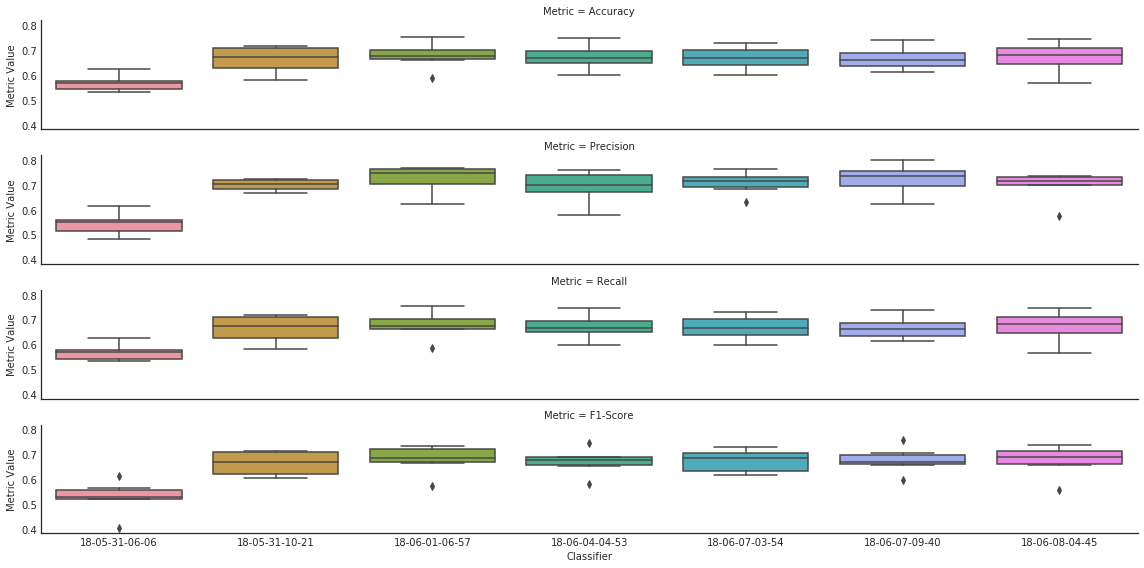

In [66]:
sns.factorplot(data=cc_results_stacked_metrics[cc_results_stacked_metrics.Dataset == 'dev'],
               x='Classifier', kind='box', y='Metric Value', row='Metric', aspect=8, size=2)

### Metrics with respect to support

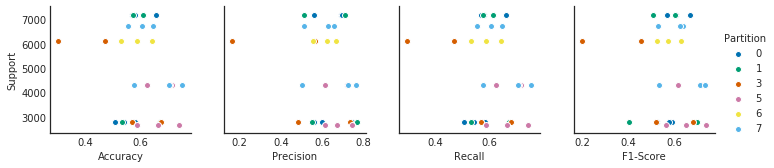

In [73]:
sns.pairplot(data=cc_results, x_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
             y_vars=['Support'], hue='Partition')

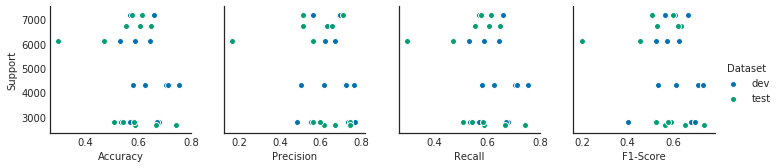

In [74]:
sns.pairplot(data=cc_results, x_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
             y_vars=['Support'], hue='Dataset')

## Learning rate

In [67]:
def learning_single_file(filename):
    result = pandas.read_csv(
        filename, sep='\t', header=None,
        names=['epoch', 'model_name', 'dev_score', 'test_score', 'max_dev_score', 'max_test_score'])
    return result

In [68]:
def learning_filenames(dirname):
    return [learning_metrics for learning_metrics in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, learning_metrics)) and 'results' in learning_metrics]

In [69]:
def learning_metrics_single_classifier(classifier_dirpath):
    """Reads all partitions for a single classifier."""
    result = []
    for index, results_file in enumerate(learning_filenames(classifier_dirpath)):
        learning_metrics = learning_single_file(os.path.join(classifier_dirpath, results_file)).drop(
            columns=['model_name', 'max_dev_score', 'max_test_score'])
        learning_metrics = learning_metrics.set_index(['epoch']).stack().reset_index().rename(
            columns={0: 'Metric Value', 'level_1': 'Dataset'})
        learning_metrics['Partition'] = re.search('.*partition(\d+).*', results_file).group(1)
        learning_metrics['Classifier'] = os.path.basename(os.path.normpath(classifier_dirpath))
        result.append(learning_metrics)
    return pandas.concat(result)

In [70]:
def learning_metrics(experiment_dirs):
    """Reads learning metrics for all classifiers"""
    classifier_learning_metrics = []
    for classifier_path in experiment_dirs:
        classifier_learning_metrics.append(learning_metrics_single_classifier(classifier_path))
    return pandas.concat(classifier_learning_metrics)

In [71]:
cc_learning = learning_metrics(CC_EXPERIMENTS_DIRS)
cc_learning[:3]

,epoch,Dataset,Metric Value,Partition,Classifier
0,1,dev_score,0.441224,5,18-05-31-06-06
1,1,test_score,0.455423,5,18-05-31-06-06
2,2,dev_score,0.446325,5,18-05-31-06-06


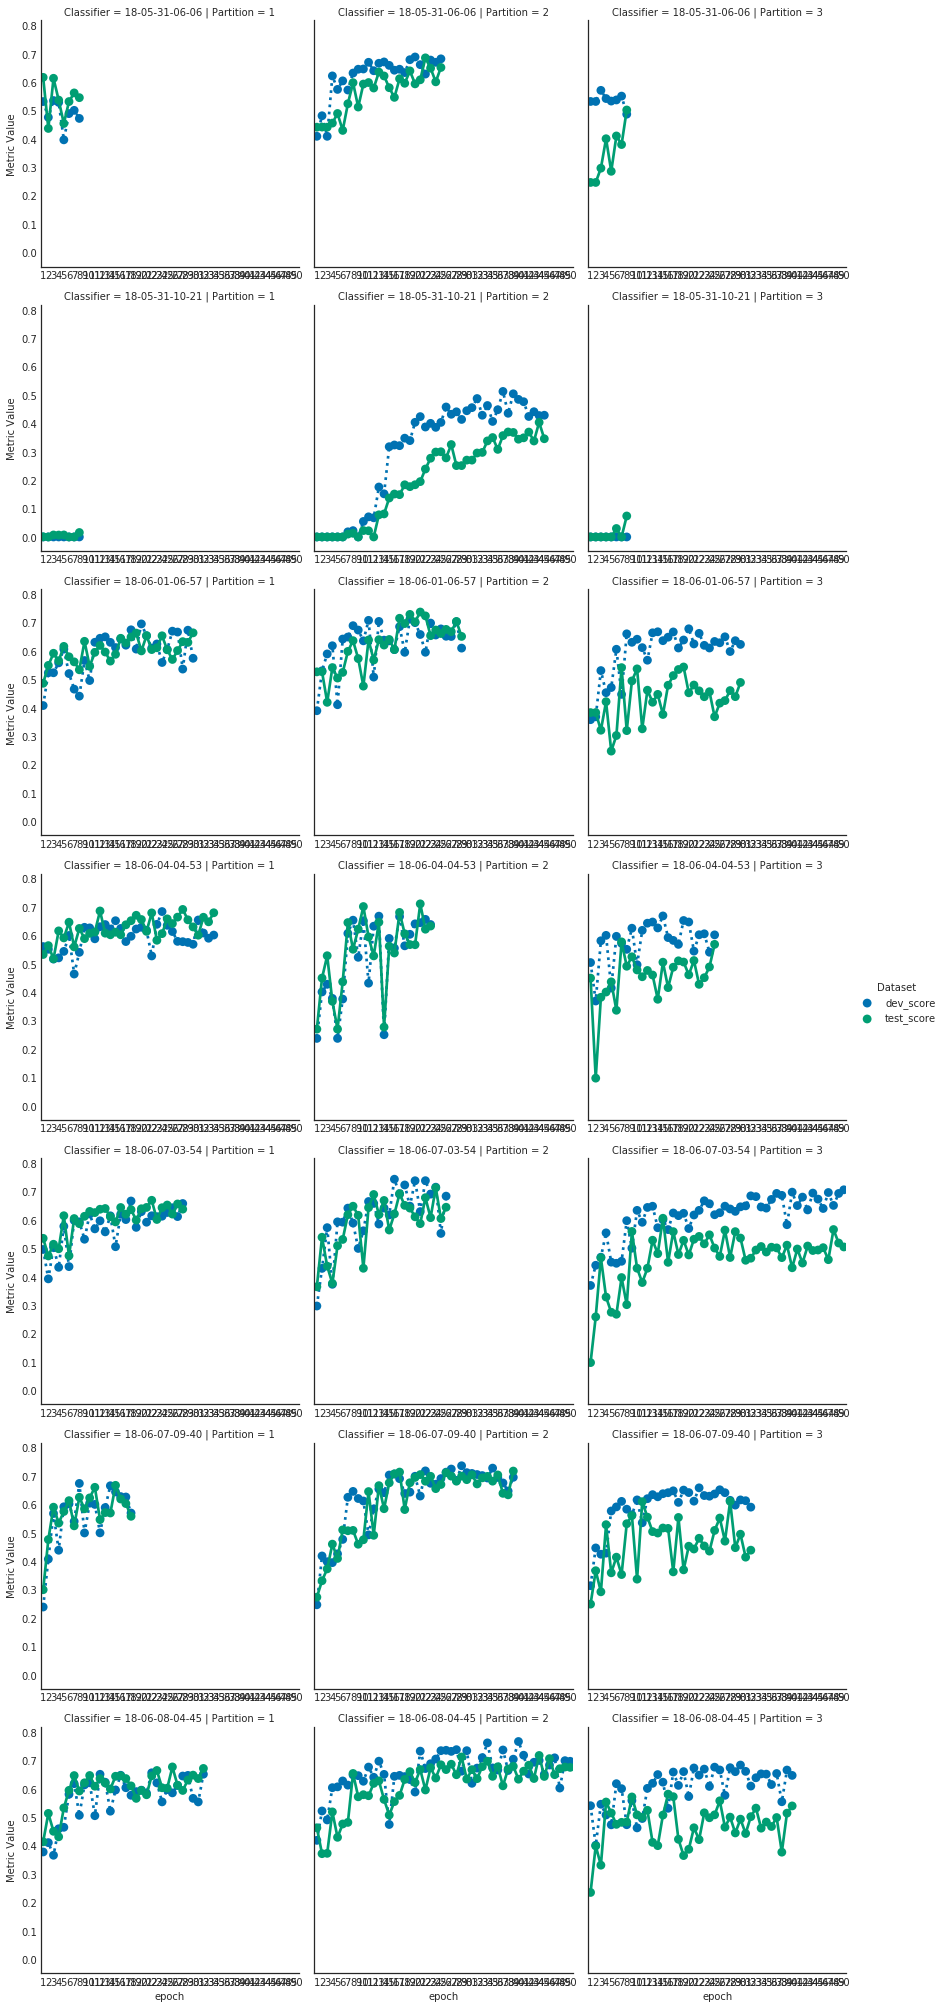

In [72]:
sns.factorplot(data=cc_learning[cc_learning.Partition.isin(['1', '2', '3'])],
               row='Classifier', x='epoch', y='Metric Value', hue='Dataset',
               linestyles=[":", "-"], col='Partition', sharex=False, hue_order=['dev_score', 'test_score'])

---

## RELATION AND COMPONENT CLASSIFICATION - Classification results

In [78]:
cc_rel_results = experiments_metrics(REL_EXPERIMENTS_DIRS)

In [79]:
cc_rel_results[cc_rel_results.Dataset == 'dev'].groupby('Classifier').agg('mean')

,Accuracy,Precision,Recall,F1-Score
Classifier,,,,
18-06-04-10-51,0.432360,0.479865,0.432360,0.434046
18-06-05-04-42,0.435701,0.435757,0.435701,0.427478
18-06-06-06-07,0.412206,0.484054,0.412206,0.425417


### Comparison between classifiers

In [75]:
METRIC_COLS = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

cc_rel_results_stacked_metrics = cc_rel_results.set_index(['Classifier', 'Dataset', 'Partition']).drop(
    columns='Support').stack().reset_index().rename(columns={0: 'Metric Value', 'level_3': 'Metric'})

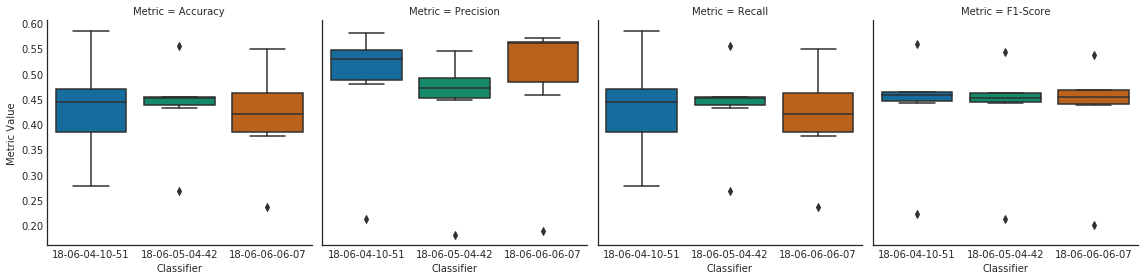

In [76]:
sns.factorplot(data=cc_rel_results_stacked_metrics[cc_rel_results_stacked_metrics.Dataset == 'dev'],
               x='Classifier', kind='box', y='Metric Value', col='Metric')

## Learning rate

In [20]:
cc_rel_learning = learning_metrics(REL_EXPERIMENTS_DIRS)
cc_rel_learning[:3]

,epoch,Dataset,Metric Value,Partition,Classifier
0,1,dev_score,0.471203,0,18-06-04-10-51
1,1,test_score,0.369272,0,18-06-04-10-51
2,2,dev_score,0.471203,0,18-06-04-10-51


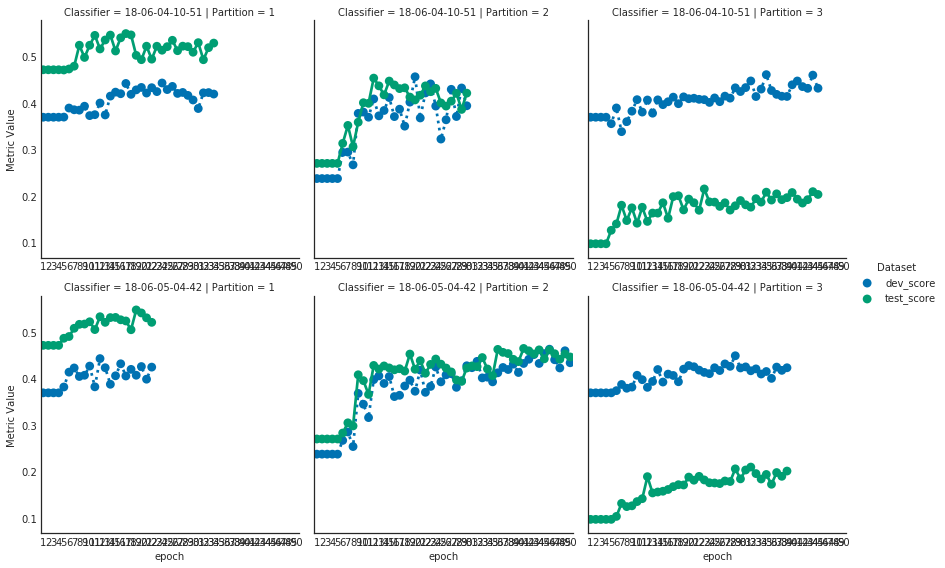

In [18]:
sns.factorplot(data=cc_rel_learning[cc_rel_learning.Partition.isin(['1', '2', '3'])],
               row='Classifier', x='epoch', y='Metric Value', hue='Dataset',
               linestyles=[":", "-"], col='Partition', sharex=False, hue_order=['dev_score', 'test_score'])

### Confusion matrix

In [108]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Args:
        confusion_matrix: numpy.ndarray
            The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
            Similarly constructed ndarrays can also be used.
        class_names: list
            An ordered list of class names, in the order they index the given confusion matrix.
        figsize: tuple
            A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
            the second determining the vertical size. Defaults to (10,7).
        fontsize: int
            Font size for axes labels. Defaults to 14.
        
    Returns:
        The resulting confusion matrix figure
    """
    df_cm = pandas.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [111]:
def plot_confusion_matrix(classifier_name, partition=0):
    for classifier_dirname in CC_EXPERIMENTS_DIRS + REL_EXPERIMENTS_DIRS:
        if not classifier_name in classifier_dirname:
            continue
        prediction_file = sorted(prediction_filenames(classifier_dirname))[partition]
        predictions = labels_single_file(os.path.join(classifier_dirname, prediction_file))
        labels = numpy.unique(numpy.concatenate([predictions['True'].values, predictions.Predicted.values]))
        cm = metrics.confusion_matrix(predictions['True'], predictions.Predicted, labels=labels)
        print_confusion_matrix(cm, labels)
        return None
    raise ValueError('Classifier not found')

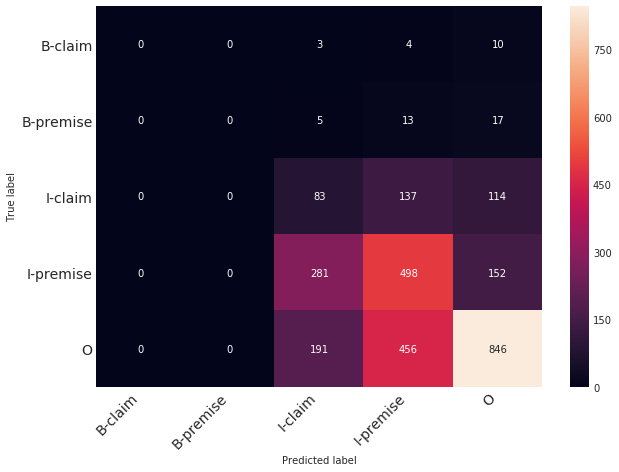

In [115]:
plot_confusion_matrix('18-05-31-06-06', partition=1)